In [1]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [2]:
pwd

'/workspace/copytodgx'

In [3]:
import numpy as np 
import pandas as pd
#import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import glob 
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import normalize
import os
from PIL import Image
from keras.optimizers import Adam

2023-09-22 03:12:12.629052: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return K.mean(numerator / (denominator + tf.keras.backend.epsilon()))

In [5]:
from tensorflow.keras.losses import binary_crossentropy
import math

def loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    eps = tf.keras.backend.epsilon()
    dice_log = tf.math.log(dice + eps)
    return bce - dice_log



In [12]:
patch_size = (1024, 1024)
step_size = 1024

In [13]:
model = tf.keras.models.load_model('/workspace/copytodgx/nodelseg_model_tf_1024_patch.h5', custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient})

In [22]:
img = '/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff'

In [23]:
img = Image.open(img).convert('L')

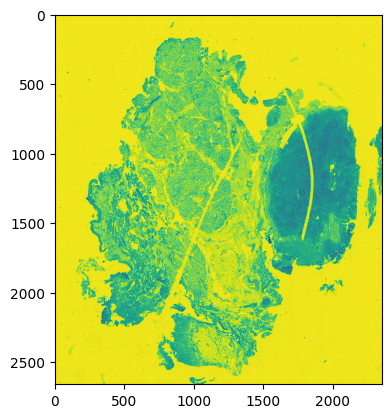

In [24]:
plt.imshow(img)

size_of_image: 3750 2682
1/1 [==============================] - 0s 25ms/step


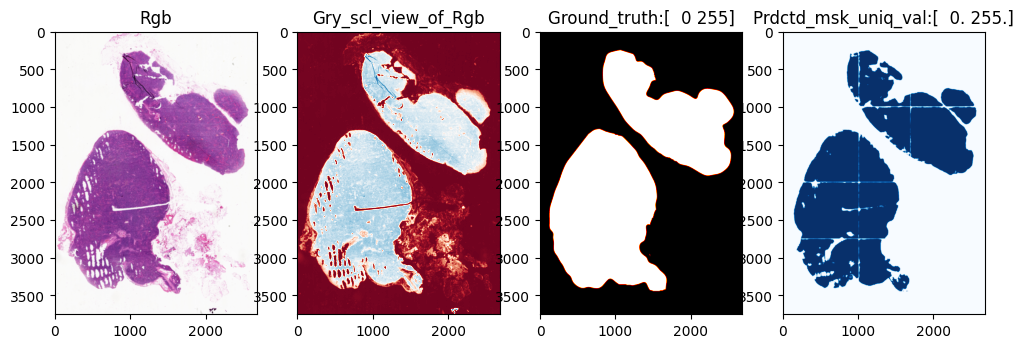

In [29]:
original_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/CAIB-T00000421OC01R01R1508HE_2.tiff', color_mode='rgb')
tiff_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/node_image_2x/CAIB-T00000421OC01R01R1508HE_2.tiff', color_mode='grayscale')
mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/CAIB-T00000421OC01R01R1508HE_2.png' , color_mode='grayscale')
tiff_array = tf.keras.preprocessing.image.img_to_array(tiff_img) /255.0


h = tiff_array.shape[0]
w = tiff_array.shape[1]
tile_size =1024
print('size_of_image:',h,w)

segmented_image = np.zeros((h, w), dtype=np.float32)
predictions = []
for x in range(0, w, tile_size):
        for y in range(0,h,tile_size):
            x_start = x
            y_start = y
            x_end = min(x_start + tile_size,w)
            y_end = min(y_start + tile_size,h)
            
            if x_end-x_start< tile_size:
                x_start=max(x_end-tile_size,0)
            if y_end-y_start<tile_size:
                y_start=max(y_end-tile_size,0)
            tile = tiff_array[y_start:y_end, x_start:x_end]
            #print(tile.shape)
            tile = np.expand_dims(tile, axis=0)
            #print(tile.shape)
            prediction = model.predict(tile)
            #print(prediction.shape)
            prd = np.argmax(prediction[0], axis=-1)
            #print(prd.shape)
            
            prd = np.reshape(prd,(tile_size,tile_size))
            #print(prd.shape)
           

            segmented_image[y_start:y_end,x_start:x_end] = prd
            #print(segmented_image.shape)
            
            
            predictions.append(prd)


fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize = (12, 8))

ax1.set_title('Rgb')
ax1.imshow(original_img, interpolation = 'bilinear')
ax2.set_title('Gry_scl_view_of_Rgb')
ax2.imshow(tiff_array,cmap='RdBu_r',interpolation ='bilinear')
ax3.set_title(f'Ground_truth:{np.unique(mask_img)}')
ax3.imshow(mask_img,cmap='gist_heat', interpolation = 'bilinear')  
ax4.set_title(f'Prdctd_msk_uniq_val:{np.unique(segmented_image)*255}')
ax4.imshow(segmented_image,cmap='Blues',interpolation = 'bilinear')
plt.show()         

size_of_image: 2659 2356
1/1 [==============================] - 0s 28ms/step


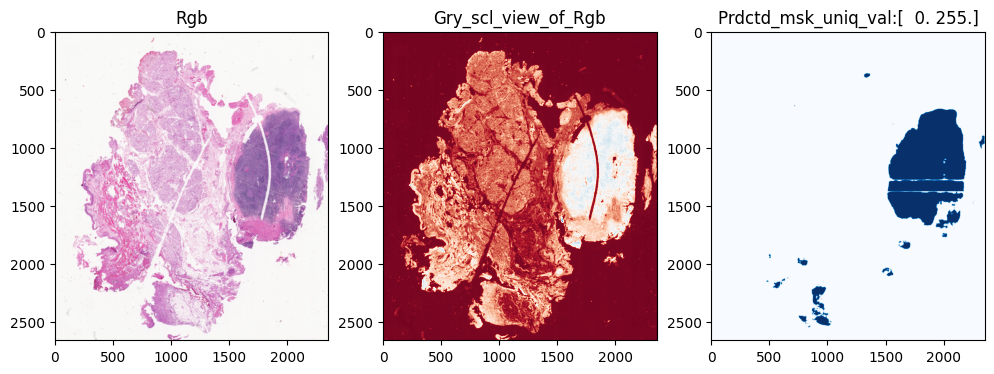

In [30]:
#never seen image before 

original_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='rgb')
tiff_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='grayscale')
#mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_masks_2x/CAIB-T00000421OC01R01R1508HE_2.png' , color_mode='grayscale')
tiff_array = tf.keras.preprocessing.image.img_to_array(tiff_img) /255.0


h = tiff_array.shape[0]
w = tiff_array.shape[1]
tile_size =1024
print('size_of_image:',h,w)

segmented_image = np.zeros((h, w), dtype=np.float32)
predictions = []
for x in range(0, w, tile_size):
        for y in range(0,h,tile_size):
            x_start = x
            y_start = y
            x_end = min(x_start + tile_size,w)
            y_end = min(y_start + tile_size,h)
            
            if x_end-x_start< tile_size:
                x_start=max(x_end-tile_size,0)
            if y_end-y_start<tile_size:
                y_start=max(y_end-tile_size,0)
            tile = tiff_array[y_start:y_end, x_start:x_end]
            #print(tile.shape)
            tile = np.expand_dims(tile, axis=0)
            #print(tile.shape)
            prediction = model.predict(tile)
            #print(prediction.shape)
            prd = np.argmax(prediction[0], axis=-1)
            #print(prd.shape)
            
            prd = np.reshape(prd,(tile_size,tile_size))
            #print(prd.shape)
           

            segmented_image[y_start:y_end,x_start:x_end] = prd
            #print(segmented_image.shape)
            
            
            predictions.append(prd)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (12, 8))

ax1.set_title('Rgb')
ax1.imshow(original_img, interpolation = 'bilinear')
ax2.set_title('Gry_scl_view_of_Rgb')
ax2.imshow(tiff_array,cmap='RdBu_r',interpolation ='bilinear')
 
ax3.set_title(f'Prdctd_msk_uniq_val:{np.unique(segmented_image)*255}')
ax3.imshow(segmented_image,cmap='Blues',interpolation = 'bilinear')
plt.show()            

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return K.mean(numerator / (denominator + tf.keras.backend.epsilon()))

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
import math

def loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    eps = tf.keras.backend.epsilon()
    dice_log = tf.math.log(dice + eps)
    return bce - dice_log


In [ ]:
model = tf.keras.models.load_model('/workspace/copytodgx/nodel_segmentation_tf_1280.h5', custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient})

In [ ]:
#thumbnail


    
img_size = 1280

    #Read Seismic image and corresponding mask
rgb_img =tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_node_image_2x/CAIB-T00000036OC01R01R0708HE_2.tiff', color_mode='rgb')
he_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_node_masks_2x/CAIB-T00000036OC01R01R0708HE_2.tiff', color_mode='grayscale')
mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/training_node_masks_2x/CAIB-T00000036OC01R01R0708HE_2.png', color_mode='grayscale')

    #Model prediction
test_img = he_img.resize((img_size, img_size))
test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
test_img = np.expand_dims(test_img, axis=0) #1,1280,1280,1

pred = model.predict(test_img) #1,1280,1280,num_classes
    
    
predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize = (12, 8))

    #Show both images
ax1.set_title('RGB image')
ax1.imshow(rgb_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Pre_processed_image')
ax2.imshow(he_img.resize((img_size, img_size)), cmap = 'RdBu_r', interpolation = 'bilinear')
ax3.set_title('Masked_image')
ax3.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
ax4.set_title('Predicted image')
ax4.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


plt.show()

In [ ]:
#never seen image before


img_size = 1280

    #Read Seismic image and corresponding mask
he_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='rgb')
mask_img = tf.keras.preprocessing.image.load_img('/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff', color_mode='grayscale')

    #Model prediction
test_img = mask_img.resize((img_size, img_size))
test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
test_img = np.expand_dims(test_img, axis=0) #1,1000,1000,1

pred = model.predict(test_img) #1,1000,1000,num_classes
    
predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
ax1.set_title('Actual image')
ax1.imshow(he_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('preprocessed_image_for_segmentation')
ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'RdBu_r', interpolation = 'bilinear')
ax3.set_title('Predicted mask')
ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


plt.show()